Experiment 1 with resnet18 transfer learning
============================================

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, models, transforms
import time
import os
from utils import *
from classes import *
from train_utils import train
from model_utils import create_model_architecture

use_gpu = torch.cuda.is_available()

print('main imports complete')

main imports complete


In [2]:
# ========================================
# Step 1. define data transform
#
# Including different forms of data augmentation
# One will include nearly all types (excluding random crops, etc. that may remove handwriting.)
# The other will include a selected set of augmentations
# Keeping 'train', 'val', and 'test' transforms just in case we want to include different functionalities
# ========================================

# Need the __name__ check to make multiprocessing work on Windows for some reason
# if __name__ == '__main__':
print("Set up data transforms.")
img_input_size = 56

selected_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        # RandomRotation does not seem to be working on Windows right now
        transforms.RandomRotation(45),

        transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5),
        transforms.RandomGrayscale(p=0.1),

        transforms.Grayscale(), # not sure why the current input is not grayscale, do grayscale conversion
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
    # should not do random transformation in val or test set
    'val': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
}

# Data augmentation and normalization for training
# Just normalization for validation
jqnet1_data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize(256),
        transforms.RandomResizedCrop(224), #apparently get an error if dont have this line
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),    
        transforms.Grayscale(),    
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
}

# data_transforms = selected_transforms
data_transforms = jqnet1_data_transforms


Set up data transforms.


In [3]:
# ========================================
# Step 2. define and load data
#
# TODO: Suggest not using data loader to load the images. Because it is slow. Every epochs, you load the 
# image data again to the RAM and then from RAM to GPU RAM. That takes a lot of time. Since the images are 
# <1GB, you can preload the images into RAM first, that will make you training way faster. 

# Note: you only has about 200MB of images, it's small. It should not take much time to load!
# ========================================


print("Create dataset and dataloader")

# hyperparameter
# batch_size = 50 # larger batch size is better so you can load more data into gpu and train faster

# data location
book_data_dir = '/home/rahul/data/printed_with_ids_harsh_filter/books-preprocessed-images'
set_types = ['train', 'val', 'test']

# Get the list of all books in the data set
books_in_data = set([b for b in os.listdir(book_data_dir)
                 if os.path.isdir(os.path.join(book_data_dir, b))])


print('Using default ImageFolder dataset.')
book_data_sets = {b : {t : datasets.ImageFolder(os.path.join(book_data_dir, b), 
                                                transform = data_transforms[t])#, transform=test_transform)
                      for t in set_types}
                 for b in books_in_data}


print('Counting images')
no_transform_datasets = {b : datasets.ImageFolder(os.path.join(book_data_dir, b)) for b in books_in_data}
image_counts = {book : {0 : 0, 1 : 0} for book in no_transform_datasets}
for book in no_transform_datasets:
    for im, target in no_transform_datasets[book]:
        image_counts[book][target] += 1
        
print(image_counts)

print("data loading complete")



Create dataset and dataloader
Using default ImageFolder dataset.
Counting images
{'Montaigne': {0: 129, 1: 538}, 'Voltaire': {0: 55, 1: 305}, 'Blackmore': {0: 36, 1: 292}, 'Defoe': {0: 107, 1: 229}, 'Browne': {0: 160, 1: 200}, 'Ascham': {0: 20, 1: 76}, 'Albin': {0: 143, 1: 31}, 'Confucius': {0: 6, 1: 165}, 'Allestree': {0: 66, 1: 212}, 'Dryden': {0: 39, 1: 9}}
data loading complete


use_gpu is True
validating on book: 'Montaigne'
Creating JQ's net1.
train counts {0: 632, 1: 1519}

Epoch 0/1
----------
Phase:train
average loss: 0.702642952405958
f1_pos: 0.5933273219116321
f1_neg: 0.41403204850584674

Phase:val
average loss: 0.6770319906489245
f1_pos: 0.9031705227077977
f1_neg: 0.32335329341317365


Epoch 1/1
----------
Phase:train
average loss: 0.6874638500156092
f1_pos: 0.6523822948970961
f1_neg: 0.40976543800861653

Phase:val
average loss: 0.6528209505946204
f1_pos: 0.8962025316455695
f1_neg: 0.174496644295302

Training complete in 0m 27s


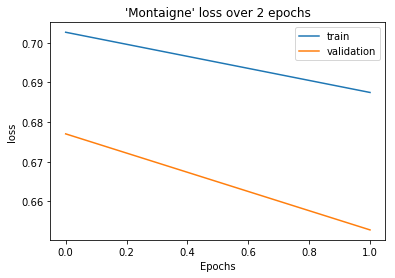

Average Training Score: 0.6950534012107836
Average Validation Score: 0.6649264706217725


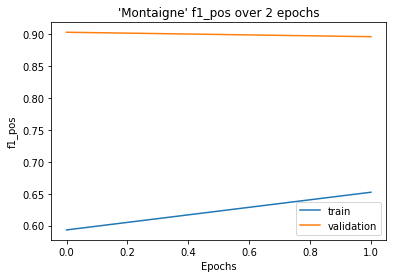

Average Training Score: 0.6228548084043641
Average Validation Score: 0.8996865271766836


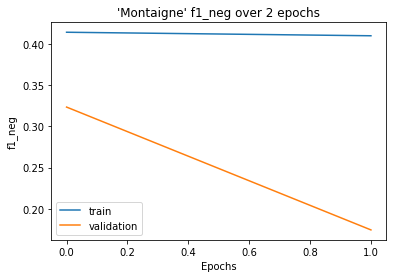

Average Training Score: 0.41189874325723164
Average Validation Score: 0.24892496885423782
Wrote metrics to 'raw_logs/Montaigne.csv'

validating on book: 'Voltaire'
Creating JQ's net1.
train counts {0: 706, 1: 1752}

Epoch 0/1
----------
Phase:train
average loss: 0.6954509627319888
f1_pos: 0.7467749641662685
f1_neg: 0.2689655172413793

Phase:val
average loss: 0.6677546269363828
f1_pos: 0.9172932330827067
f1_neg: 0


Epoch 1/1
----------
Phase:train
average loss: 0.6726403209315368
f1_pos: 0.7954386781475447
f1_neg: 0.3435399551904406

Phase:val
average loss: 0.6635461565521028
f1_pos: 0.8942307692307692
f1_neg: 0.31249999999999994

Training complete in 0m 24s


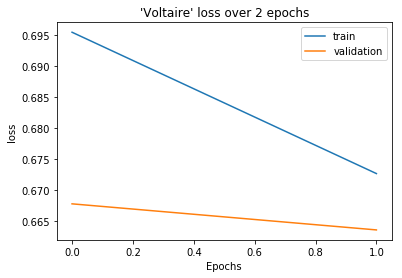

Average Training Score: 0.6840456418317629
Average Validation Score: 0.6656503917442428


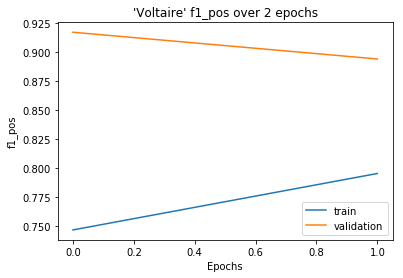

Average Training Score: 0.7711068211569065
Average Validation Score: 0.905762001156738


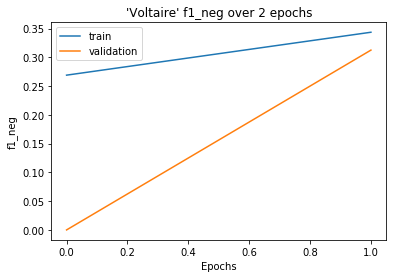

Average Training Score: 0.30625273621591
Average Validation Score: 0.15624999999999997
Wrote metrics to 'raw_logs/Voltaire.csv'

validating on book: 'Blackmore'
Creating JQ's net1.
train counts {0: 725, 1: 1765}

Epoch 0/1
----------
Phase:train
average loss: 0.6949253651248046
f1_pos: 0.7883408071748879
f1_neg: 0.19727891156462588

Phase:val
average loss: 0.6615036177199062
f1_pos: 0.9419354838709678
f1_neg: 0


Epoch 1/1
----------
Phase:train
average loss: 0.6897971165188667
f1_pos: 0.8092613009922821
f1_neg: 0.21435059037238877

Phase:val
average loss: 0.6482805089979637
f1_pos: 0.9419354838709678
f1_neg: 0

Training complete in 0m 24s


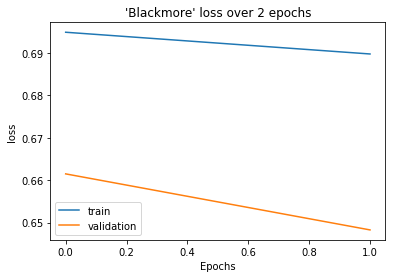

Average Training Score: 0.6923612408218356
Average Validation Score: 0.654892063358935


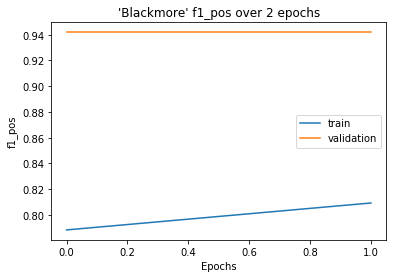

Average Training Score: 0.798801054083585
Average Validation Score: 0.9419354838709678


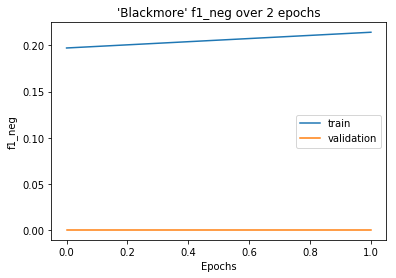

Average Training Score: 0.20581475096850732
Average Validation Score: 0.0
Wrote metrics to 'raw_logs/Blackmore.csv'

validating on book: 'Defoe'
Creating JQ's net1.
train counts {0: 654, 1: 1828}

Epoch 0/1
----------
Phase:train
average loss: 0.6908453455455258
f1_pos: 0.5128700128700129
f1_neg: 0.4011075949367089

Phase:val
average loss: 0.7011888541636013
f1_pos: 0.8078994614003591
f1_neg: 0.06956521739130435


Epoch 1/1
----------
Phase:train
average loss: 0.6644823970821752
f1_pos: 0.6943699731903485
f1_neg: 0.4018887722980063

Phase:val
average loss: 0.6805797478272801
f1_pos: 0.7927565392354126
f1_neg: 0.4114285714285714

Training complete in 0m 24s


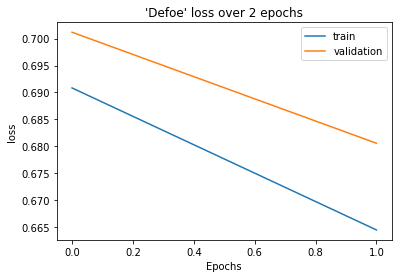

Average Training Score: 0.6776638713138505
Average Validation Score: 0.6908843009954407


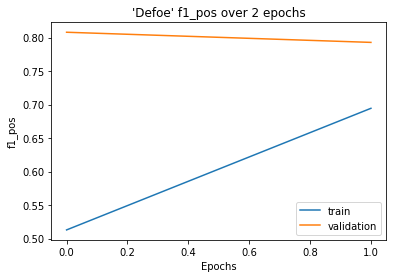

Average Training Score: 0.6036199930301807
Average Validation Score: 0.8003280003178859


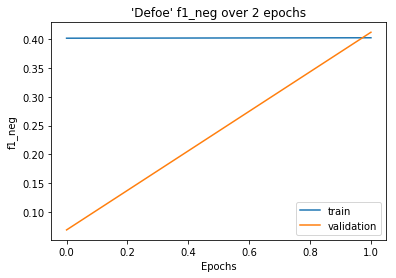

Average Training Score: 0.40149818361735756
Average Validation Score: 0.24049689440993788
Wrote metrics to 'raw_logs/Defoe.csv'

validating on book: 'Browne'
Creating JQ's net1.
train counts {0: 601, 1: 1857}

Epoch 0/1
----------
Phase:train
average loss: 0.6953423729680632
f1_pos: 0.5168253968253969
f1_neg: 0.38777152051488334

Phase:val
average loss: 0.6920738601022296
f1_pos: 0.6666666666666667
f1_neg: 0.36947791164658633


Epoch 1/1
----------
Phase:train
average loss: 0.6620824450800147
f1_pos: 0.6413232733604178
f1_neg: 0.4356164383561644

Phase:val
average loss: 0.700836623708407
f1_pos: 0.7126865671641791
f1_neg: 0.16304347826086957

Training complete in 0m 24s


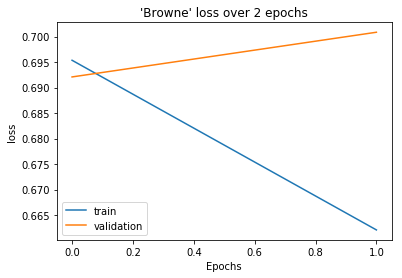

Average Training Score: 0.678712409024039
Average Validation Score: 0.6964552419053183


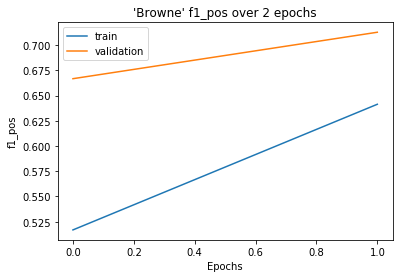

Average Training Score: 0.5790743350929073
Average Validation Score: 0.6896766169154229


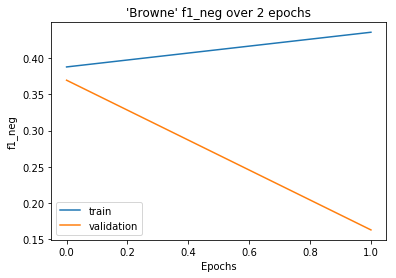

Average Training Score: 0.4116939794355239
Average Validation Score: 0.26626069495372795
Wrote metrics to 'raw_logs/Browne.csv'

validating on book: 'Ascham'
Creating JQ's net1.
train counts {0: 741, 1: 1981}

Epoch 0/1
----------
Phase:train
average loss: 0.7048488243240427
f1_pos: 0.6576746695441057
f1_neg: 0.34214618973561434

Phase:val
average loss: 0.6801288338998953
f1_pos: 0.9241379310344827
f1_neg: 0.7659574468085106


Epoch 1/1
----------
Phase:train
average loss: 0.6926328016139668
f1_pos: 0.6172768878718535
f1_neg: 0.37476635514018686

Phase:val
average loss: 0.6799522091945013
f1_pos: 0.6306306306306306
f1_neg: 0.49382716049382713

Training complete in 0m 22s


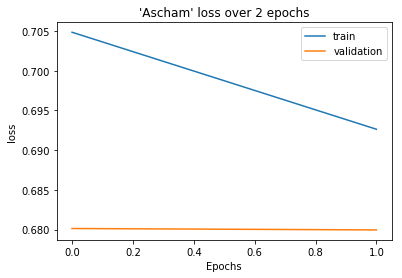

Average Training Score: 0.6987408129690047
Average Validation Score: 0.6800405215471983


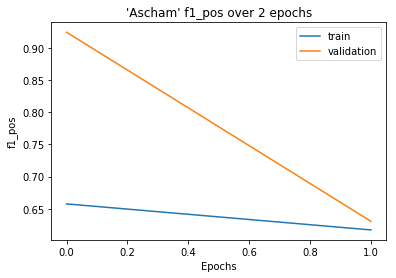

Average Training Score: 0.6374757787079797
Average Validation Score: 0.7773842808325566


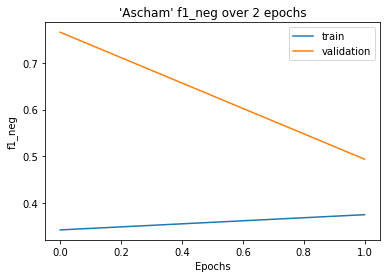

Average Training Score: 0.35845627243790057
Average Validation Score: 0.6298923036511689
Wrote metrics to 'raw_logs/Ascham.csv'

validating on book: 'Albin'
Creating JQ's net1.
train counts {0: 618, 1: 2026}

Epoch 0/1
----------
Phase:train
average loss: 0.6970966091555344
f1_pos: 0.2891849529780564
f1_neg: 0.41180285343709466

Phase:val
average loss: 0.6226132224346029
f1_pos: 0
f1_neg: 0.9022082018927445


Epoch 1/1
----------
Phase:train
average loss: 0.6932923456216383
f1_pos: 0.26645264847512035
f1_neg: 0.4185750636132316

Phase:val
average loss: 0.6524720925024186
f1_pos: 0
f1_neg: 0.9022082018927445

Training complete in 0m 22s


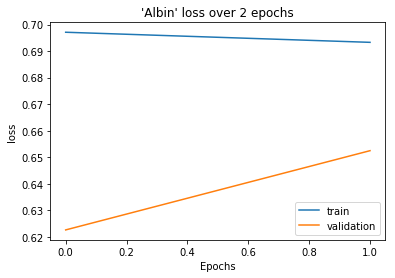

Average Training Score: 0.6951944773885863
Average Validation Score: 0.6375426574685108


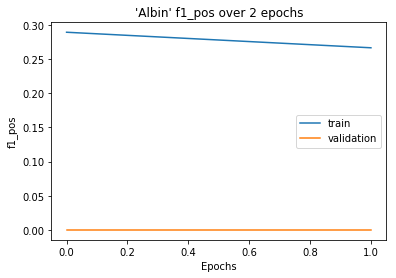

Average Training Score: 0.2778188007265884
Average Validation Score: 0.0


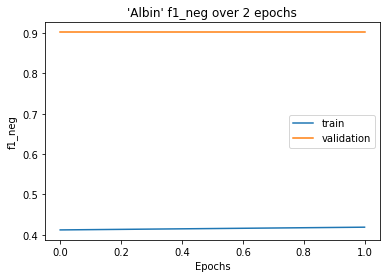

Average Training Score: 0.41518895852516313
Average Validation Score: 0.9022082018927445
Wrote metrics to 'raw_logs/Albin.csv'

validating on book: 'Confucius'
Creating JQ's net1.
train counts {0: 755, 1: 1892}

Epoch 0/1
----------
Phase:train
average loss: 0.7006872321291965
f1_pos: 0.5650419124495498
f1_neg: 0.41987577639751555

Phase:val
average loss: 0.6921126438163178
f1_pos: 0.8384879725085911
f1_neg: 0.0784313725490196


Epoch 1/1
----------
Phase:train
average loss: 0.69331400232843
f1_pos: 0.5895432692307692
f1_neg: 0.40814558058925476

Phase:val
average loss: 0.746998731852972
f1_pos: 0
f1_neg: 0.06779661016949151

Training complete in 0m 23s


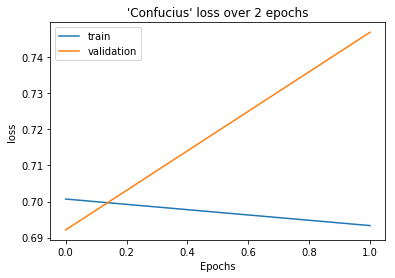

Average Training Score: 0.6970006172288132
Average Validation Score: 0.719555687834645


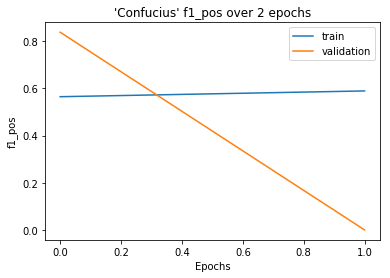

Average Training Score: 0.5772925908401595
Average Validation Score: 0.41924398625429554


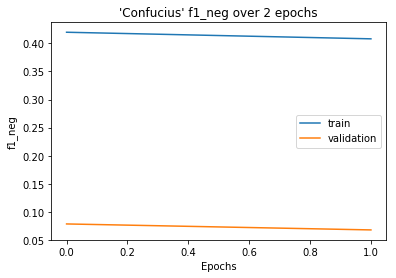

Average Training Score: 0.41401067849338513
Average Validation Score: 0.07311399135925556
Wrote metrics to 'raw_logs/Confucius.csv'

validating on book: 'Allestree'
Creating JQ's net1.
train counts {0: 695, 1: 1845}

Epoch 0/1
----------
Phase:train
average loss: 0.6995846752666937
f1_pos: 0.45877163216830674
f1_neg: 0.40684269245072513

Phase:val
average loss: 0.6869453367569464
f1_pos: 0
f1_neg: 0.3837209302325581


Epoch 1/1
----------
Phase:train
average loss: 0.686656232756702
f1_pos: 0.5771235817233976
f1_neg: 0.41936842105263156

Phase:val
average loss: 0.6343416974698897
f1_pos: 0.8946015424164525
f1_neg: 0.7544910179640719

Training complete in 0m 24s


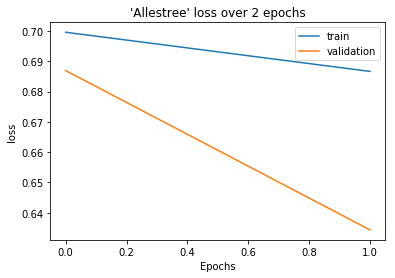

Average Training Score: 0.6931204540116978
Average Validation Score: 0.660643517113418


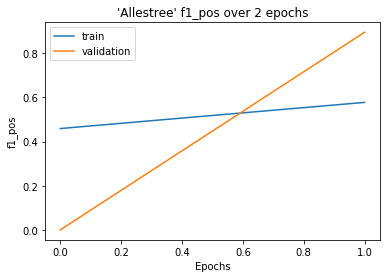

Average Training Score: 0.5179476069458522
Average Validation Score: 0.44730077120822626


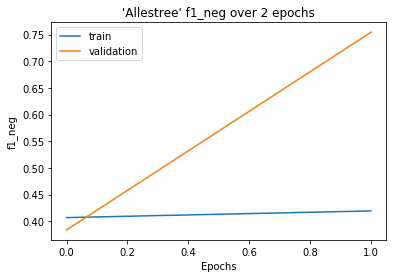

Average Training Score: 0.41310555675167837
Average Validation Score: 0.569105974098315
Wrote metrics to 'raw_logs/Allestree.csv'

validating on book: 'Dryden'
Creating JQ's net1.
train counts {0: 722, 1: 2048}

Epoch 0/1
----------
Phase:train
average loss: 0.7028526972167622
f1_pos: 0.7640344747262986
f1_neg: 0.2457185405807893

Phase:val
average loss: 0.7330795526504517
f1_pos: 0.3157894736842105
f1_neg: 0


Epoch 1/1
----------
Phase:train
average loss: 0.6918031209491516
f1_pos: 0.7368675865407891
f1_neg: 0.2777408637873754

Phase:val
average loss: 0.6945347785949707
f1_pos: 0.29268292682926833
f1_neg: 0.4727272727272727

Training complete in 0m 21s


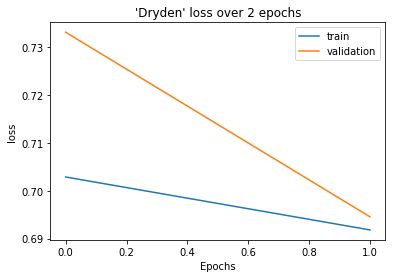

Average Training Score: 0.6973279090829569
Average Validation Score: 0.7138071656227112


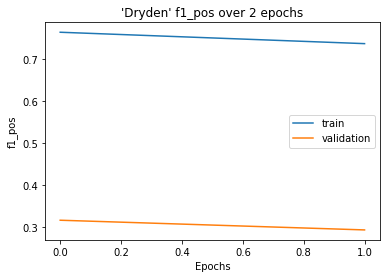

Average Training Score: 0.7504510306335439
Average Validation Score: 0.3042362002567394


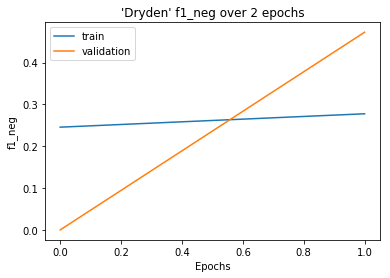

Average Training Score: 0.2617297021840823
Average Validation Score: 0.23636363636363636
Wrote metrics to 'raw_logs/Dryden.csv'

training complete


In [6]:
# ========================================
# Step 5. execute the train process
# ========================================

from train_utils import train

# overriding to use CPU when GPU is busy
use_gpu = True
print('use_gpu is ' + str(use_gpu))
device_name = 'cuda' if use_gpu else 'cpu'

batch_size = 50 # larger batch size is better so you can load more data into gpu and train faster

phases = ['train', 'val']
metric_types = ['loss', 'tn', 'fp', 'fn', 'tp', 'f1_pos', 'f1_neg']
metric_types_plot = ['loss', 'f1_pos', 'f1_neg']
metric_names_all = [p+'-'+m for p in phases for m in metric_types]
metric_names_plot = [p+'-'+m for p in phases for m in metric_types_plot]

all_metrics = {book : {metric : [] for metric in metric_names_all} for book in books_in_data}

# train parameters
num_training_epochs = 2
# num_training_epochs = 100

# leave-one-book-out cross validation
for val_book in books_in_data:
    print("validating on book: '" + str(val_book) + "'")
    
    # define the train and validation loaders
    train_books = books_in_data - set([val_book])

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.ConcatDataset([book_data_sets[b]['train'] for b in book_data_sets]),
        batch_size=batch_size,
        shuffle=True, # make sure you shuffle the data
        num_workers=4)
    val_loader = torch.utils.data.DataLoader(book_data_sets[val_book]['val'],
                                            batch_size = batch_size,
                                            shuffle = True,
                                            num_workers = 4)
    
    # get the model architecture
    model = create_model_architecture('jq_net1', use_gpu = True)
    
    # model hyperparameters
    
    # check weights added to CrossEntropyLoss [1, 1/(#pos in train / #neg in train)]
    train_counts = {c : sum([image_counts[b][c] for b in train_books]) for c in [0,1]}
    print('train counts', train_counts)
    loss_weights = torch.FloatTensor([1, float(train_counts[0])/float(train_counts[1])])
    loss_weights = loss_weights.to(device_name)
    
    criterion = nn.CrossEntropyLoss(weight = loss_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # train
    trained_model, train_metrics = train(model,
                                         criterion,
                                         optimizer,
                                         train_loader,
                                         val_loader,
                                         num_epochs=num_training_epochs,
                                         use_gpu = use_gpu)
    
    # update metrics dicts
    all_metrics[str(val_book)] = train_metrics
    
    # plot all metrics
    for metric in metric_types_plot:
        plot_values(all_metrics[str(val_book)]['train-' + str(metric)],
                   all_metrics[str(val_book)]['val-' + str(metric)],
                   "'" + str(val_book) + "' " + str(metric) + " over " + str(num_training_epochs) + " epochs",
                   ylabel = str(metric))
        
    # write metrics to file
    write_metrics_to_csv(all_metrics[str(val_book)], metric_names_all, 'raw_logs', str(val_book) + '.csv')
    
    print()
    
    # remove the break as needed
#     break


print("training complete")

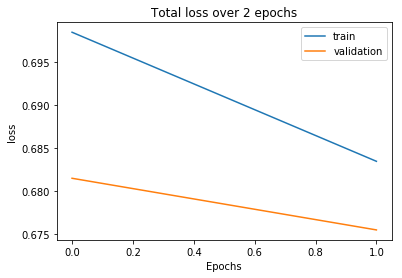

Average Training Score: 0.6909220834883332
Average Validation Score: 0.6784398018212192


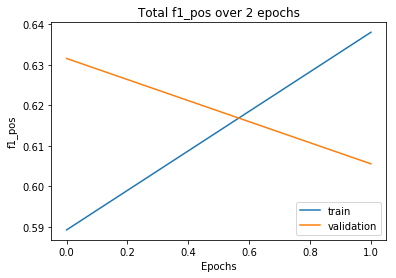

Average Training Score: 0.6136442819622068
Average Validation Score: 0.6185553867989517


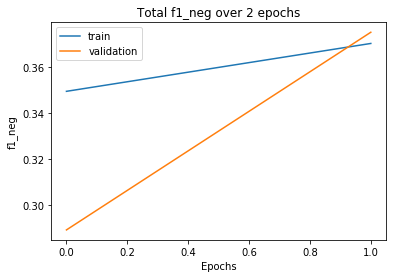

Average Training Score: 0.35996495618867397
Average Validation Score: 0.33226166655830236


In [7]:
# compute and plot total loss
# total_train_loss = [sum([all_train_loss[b][i] for b in all_train_loss]) for i in range(num_training_epochs)]
# total_val_loss = [sum([all_val_loss[b][i] for b in all_val_loss]) for i in range(num_training_epochs)]
# plot_losses(total_train_loss, total_val_loss, "Total losses over " + str(num_training_epochs) + " epochs")

total_metrics = {metric : [np.mean([all_metrics[book][metric][epoch] for book in all_metrics])
                           for epoch in range(num_training_epochs)]
                 for metric in metric_names_plot}

for metric in metric_types_plot:
    plot_values(total_metrics['train-' + str(metric)],
                   total_metrics['val-' + str(metric)],
                   "Total " + str(metric) + " over " + str(num_training_epochs) + " epochs",
                   ylabel = str(metric))
